# Project 3 - Part 2 - Node Classification
## - Represent nodes through spectral graph analysis (i.e. eigendecomposition).
## - Represent nodes by node2vec embeddings.

<br><br>

## Diogo Monteiro Martins - 120574
## Guilherme do Casal Martins - 102587
<br>

## Master in Data Science
## Mining Large Scale Datasets
<br>

<br>

## Library Imports

In [121]:
try:
    import networkx as nx
    import stellargraph
    from scipy.sparse.linalg import eigsh
    import numpy as np
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    from stellargraph.data import BiasedRandomWalk
    from stellargraph.data import UnsupervisedSampler
    from stellargraph.data import BiasedRandomWalk
    from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
    from stellargraph.layer import Node2Vec, link_classification
    from tensorflow import keras
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.metrics import accuracy_score
except:
    !pip install networkx
    !pip install stellargraph
    !pip install scipy
    !pip install numpy
    !pip install scikit-learn
    !pip install matplotlib
    !pip install tensorflow
    import networkx as nx
    import stellargraph
    from scipy.sparse.linalg import eigsh
    import numpy as np
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    from stellargraph.data import BiasedRandomWalk
    from stellargraph.data import UnsupervisedSampler
    from stellargraph.data import BiasedRandomWalk
    from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
    from stellargraph.layer import Node2Vec, link_classification
    from tensorflow import keras
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.metrics import accuracy_score

<br>

## Load the Cora Node Dataset

In [122]:
datasets = stellargraph.datasets

cora_graph, node_subjects = datasets.Cora().load(largest_connected_component_only=True)

print(cora_graph.info())
print('\n\n',node_subjects.value_counts().to_frame())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


                         count
subject                      
Neural_Networks           726
Genetic_Algorithms        406
Probabilistic_Methods     379
Theory                    344
Case_Based                285
Reinforcement_Learning    214
Rule_Learning             131


<br>

## Spectral Graph Analysis with Eigen Decomposition Embedding

Algorithm Steps:
- Compute the Laplacian Matrix
- Compute the first *e* eigen values and the corresponding eigen values
- Select multiple *ev* eigen vectors to further classification of the nodes of the data (from the second eigen value onwards)

In [123]:
# Convert the cora dataset to a networkx graph
G = cora_graph.to_networkx()

# Compute the Adjancy Matrix
A = nx.adjacency_matrix(G)

# Compute the Degree Matrix
D = nx.degree(G)

# Compute the Laplacian Matrix
L = nx.laplacian_matrix(G)

# Compute the first k eigenvectors of the Laplacian matrix
k = 129
eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')

# Select the 10 eigenvectors corresponding to the 10 smallest eigenvalues (starting in the second one)
spectral_embeddings = eigenvectors[:, 1:]

Two-dimensional visualization of the embeddings

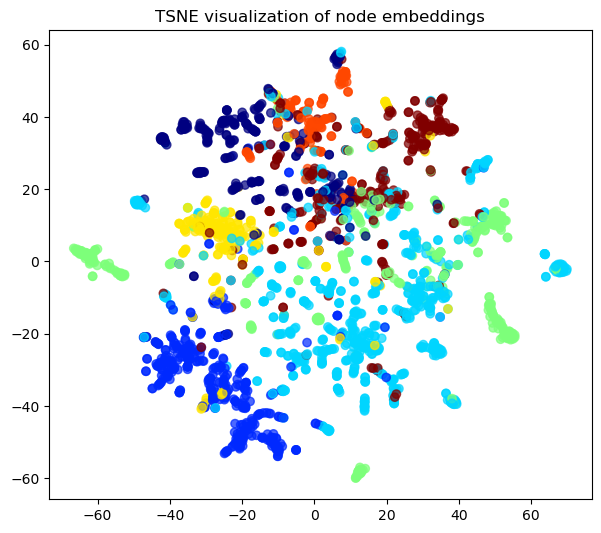

In [124]:
transform = TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(spectral_embeddings)

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_subjects))}
node_colours = [label_map[target] for target in node_subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

<br>

## Train and Evaluate the Classifier For the Eigen Decomposition Embedding

In [125]:
X = spectral_embeddings
y = np.array(node_subjects)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None, random_state=3)

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


In [126]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.7831917746982566

<br>

## Node2Vec Embeddings

In [127]:
# Obtain the cora dataset graph
G = cora_graph

# Define the parameters for the random walk
walk_number = 100
walk_length = 5

# Generate the biased random walker to perform context node sampling (list of nodes ids called corpus)
walker = BiasedRandomWalk(
    G,
    n=walk_number,
    length=walk_length,
    p=0.5, 
    q=2.0,  
)

# Create the UnsupervisedSampler instance with the biased random walker
unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

# Set the parameters for training
batch_size = 50
epochs = 2

# Define a training generator which returns a batch of pairs per iteration (index of target node, index of context node, label of node pair)
generator = Node2VecLinkGenerator(G, batch_size)

# Define the embedding dimension
emb_size = 128

# Create the Node2Vec model
node2vec = Node2Vec(emb_size, generator=generator)
x_inp, x_out = node2vec.in_out_tensors()

# Perform the dot product of the input embedding of the target node and the output embedding of the context node followed by a sigmoid activation
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

# Create the keras model with the Node2Vec and prediction layers
model = keras.Model(inputs=x_inp, outputs=prediction)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

# Fit the model
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
39760/39760 [==============================] - 266s 7ms/step - loss: 0.3010 - binary_accuracy: 0.8503
Epoch 2/2
39760/39760 [==============================] - 273s 7ms/step - loss: 0.1089 - binary_accuracy: 0.9642


Two-dimensional visualization of the embeddings

50/50 [==============================] - 0s 3ms/step


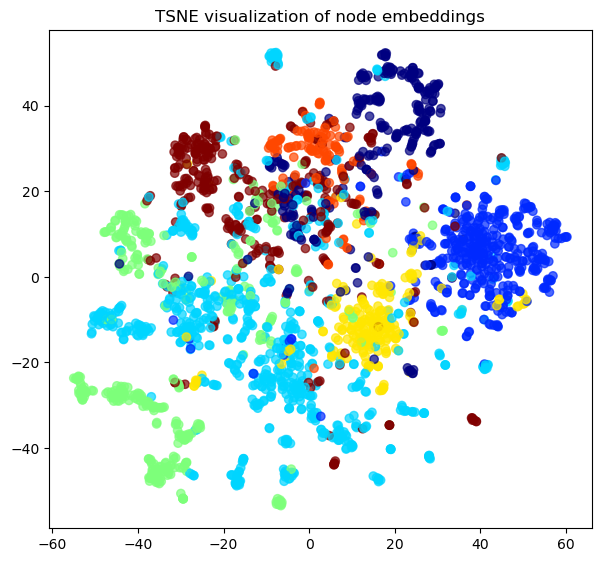

In [128]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

node_gen = Node2VecNodeGenerator(G, batch_size).flow(node_subjects.index)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

transform = TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_subjects))}
node_colours = [label_map[target] for target in node_subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

<br>

## Train and Evaluate the Classifier For the Node2Vec

In [129]:
X = node_embeddings
y = np.array(node_subjects)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None, , random_state=3)

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


In [130]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.715690657130085